# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
objs = np.array([8., 2.])
objs /= np.sum(objs)
entropy = 0
for p in objs:
    entropy -= 0 if not p else p * np.log2(p)
entropy

0.7219280948873623

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
objs = np.array([8., 2.])
objs /= np.sum(objs)
gini = 0
for p in objs:
    gini += p * (1 - p)
gini

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
objs = np.array([1, 10, 15, 18, 100, 30, 50, 61, 84, 47])
print(f'Если функция потерь MSE, то {np.mean(objs)}')
print(f'Если функция потерь MAE, то {np.median(objs)}')

Если функция потерь MSE, то 41.6
Если функция потерь MAE, то 38.5


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [7]:
def gini(y):
    answer, y = 0, pd.Series(y)
    for p in y.value_counts() / y.shape[0]:
        answer += p * (1 - p)
    return answer

def dispersion(y):
    return y.std() ** 2

def information_gain(X, y, threshold, feature_type, task):
    left, right = None, None
    match feature_type:
        case 'categorical':
            left, right = y.loc[X[X == threshold].index], y.loc[X[X != threshold].index]
        case 'real':
            left, right = y.loc[X[X <= threshold].index], y.loc[X[X > threshold].index]
    S, S1, S2 = None, None, None
    match task:
        case 'classification':
            S, S1, S2 = gini(y), gini(left), gini(right)
        case 'regression':
            S, S1, S2 = dispersion(y), dispersion(left), dispersion(right)
    IG = S - S1 * left.shape[0] / y.shape[0] - S2 * right.shape[0] / y.shape[0]
    if np.isnan(IG):
        IG = 0
    return IG

In [8]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    unique, thresholds, criterions = np.unique(feature_vector), None, None
    criterion_best, threshold_best = None, None

    match feature_type:
        case 'real':
           thresholds = (unique[1:] + unique[:-1]) / 2
        case 'categorical':
           thresholds = unique

    if unique.shape[0] > 1:

        criterions = np.array([information_gain(
            pd.Series(feature_vector), pd.Series(target_vector),
            threshold, feature_type, task
        ) for threshold in thresholds])

        index_best = np.argmax(criterions)
        criterion_best = criterions[index_best]
        threshold_best = thresholds[index_best]

    return thresholds, criterions, threshold_best, criterion_best

Эту функцию можно протестировать на датасете `Boston` из `fairlearn`.

In [9]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.2 MB/s eta 0:00:00


In [10]:
from fairlearn.datasets import fetch_boston
X, y = fetch_boston(return_X_y=True)

/usr/local/lib/python3.11/dist-packages/fairlearn/datasets/_fetch_boston.py:133: DataFairnessWarning: You are about to use a dataset with known fairness issues.
  warnings.warn(DataFairnessWarning(msg))


In [11]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), y,
    task="regression", feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [12]:
class DecisionTree:

    def __init__(
        self,
        feature_types: dict[str, str],
        target_name: str,
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types.values()))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # название столбца с целевой переменной
        self._target_name = target_name

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: pd.DataFrame,
        sub_y: pd.Series,
        node: dict
    ) -> None:
        # print('Start')
        # критерий останова
        # print(f'Shape: {sub_y.shape[0]}')
        if np.all(sub_y == sub_y.iloc[0]):
            node["type"] = "terminal"
            node["class"] = sub_y.iloc[0]
            return

        # print('Objects differ')

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in sub_X:
            feature_type = self._feature_types[feature]

            # подготавливаем признак для поиска оптимального порога
            feature_vector = sub_X[feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or (gini is not None and gini > gini_best):
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (feature_vector <= threshold_best)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (feature_vector == threshold_best)
                else:
                    raise ValueError
        # print('End of cycle')

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # print('feature_best is not None')

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
        # print('After feature types')

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])
        # print(f'Done with children')

    def _predict_node(self, x: pd.Series, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        best_feature = node['feature_split']
        feature_type = self._feature_types[best_feature]
        if (feature_type == 'categorical' and x[best_feature] == node['category_split']) or \
            (feature_type == 'real' and x[best_feature] <= node['threshold']):
            return self._predict_node(x, node['left_child'])
        return self._predict_node(x, node['right_child'])

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        indices, predicted = [], []
        for index, x in X.iterrows():
            indices.append(index)
            predicted.append(self._predict_node(x, self._tree))

        return pd.DataFrame({self._target_name: predicted}, index=indices)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [13]:
students = pd.read_csv('students.csv', index_col=0)
X_s, y_s = students.drop(columns='UNS'), students['UNS']
X_s.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


In [14]:
def get_dtypes_dict(X: pd.DataFrame) -> dict:
    index = X.dtypes.index
    types = [
        'categorical' if isinstance(dtype, pd.CategoricalDtype) or dtype == 'object'
         else 'real' for dtype in X.dtypes.values
    ]
    return dict(zip(index, types))

In [15]:
tree1 = DecisionTree(get_dtypes_dict(X_s), y_s.name)
tree1.fit(X_s, y_s)

Построим кривые "порог - значение критерия Джини для 5 признаков"

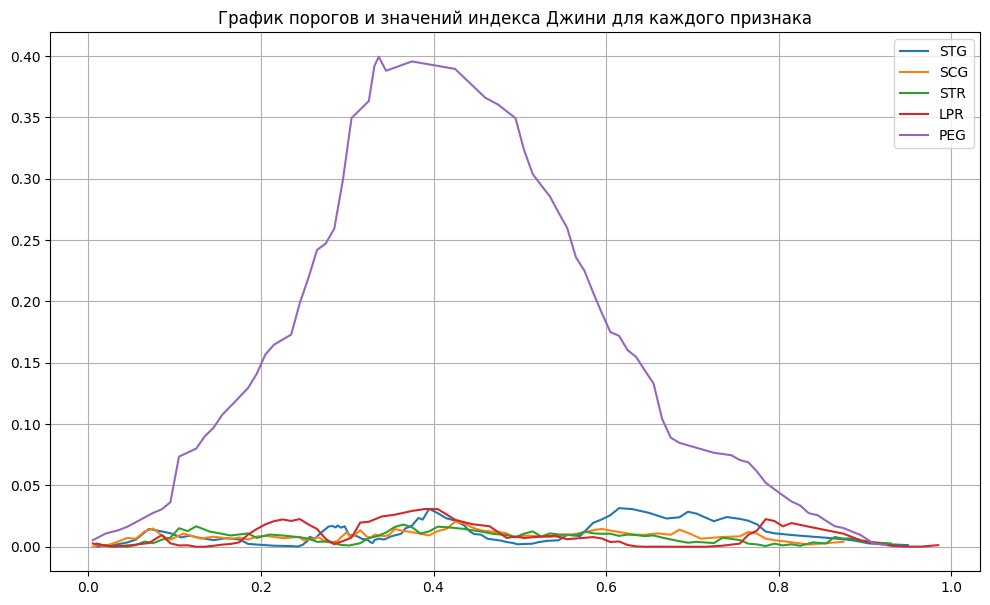

In [16]:
_, ax = plt.subplots(figsize=(12, 7))
for feature in X_s:
    thresholds, criterions, _, _ = find_best_split(X_s[feature], y_s, 'classification', 'real')
    plt.plot(thresholds, criterions, label=feature)
plt.grid()
plt.legend()
plt.title('График порогов и значений индекса Джини для каждого признака')
plt.show()

Построим диаграммы рассеяния

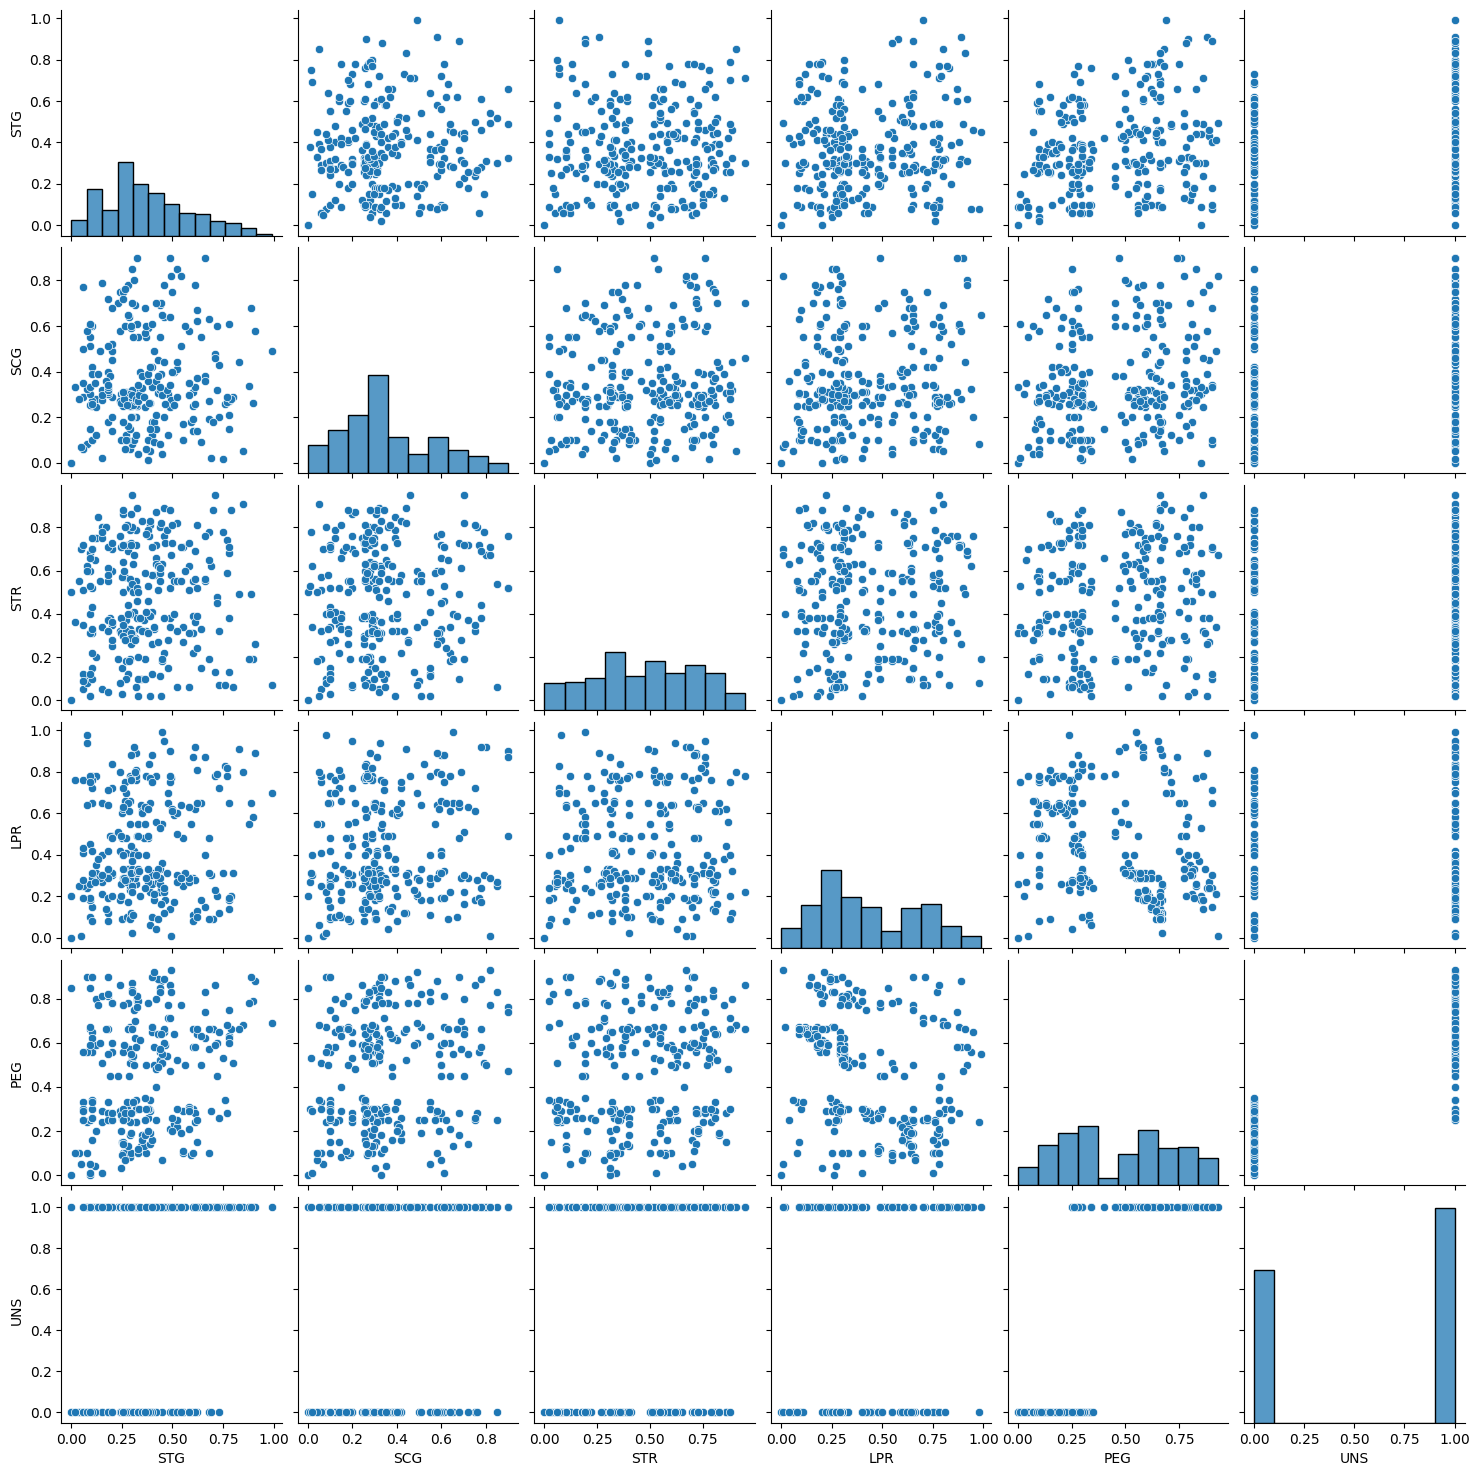

In [17]:
import seaborn as sns
sns.pairplot(students)
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ**:

1) Согласно графику кривых лучше всего делить выборку по признаку PEG (успешность сдачи пользователем экзаменов)

2) Это согласуется с диаграммами рассеяния. Там видно, что осовная часть тех, кто хуже сдаёт экзамены, в итоге принадлежит классу 0 (имеют низкий уровень знаний)

3) Признаки, по которым выборка делится почти идеально (а такой только один) имеют вид параболы

4) В свою очередь, те признаки, по которым деление практически невозможно, имеют вид кривой, которая в своих точках имеет малый угол наклона по сравнению с осью абсцисс

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [18]:
from sklearn.preprocessing import LabelEncoder
mushrooms = pd.read_csv('agaricus-lepiota.data')
label_encoder = LabelEncoder()

for feature in mushrooms:
    mushrooms[feature] = LabelEncoder().fit_transform(mushrooms[feature])
    if feature != 'p':
        mushrooms[feature] = mushrooms[feature].astype(object)

X_m, y_m = mushrooms.drop(columns='p'), mushrooms['p']

In [19]:
from sklearn.model_selection import train_test_split
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=0.5, shuffle=True)

In [20]:
tree2 = DecisionTree(get_dtypes_dict(X_m_train), y_m_train.name)
tree2.fit(X_m_train, y_m_train)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_m_test, tree2.predict(X_m_test))

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [30]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [23]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

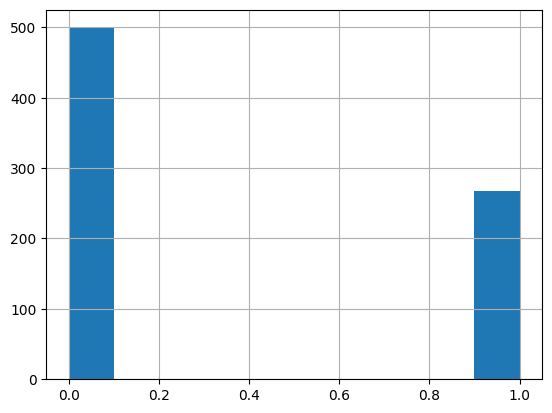

In [24]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [25]:
X, y = data.drop(columns='Outcome'), data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=True, test_size=0.3)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [51]:
from tqdm.auto import tqdm

In [52]:
best_max_depth, best_min_samples_leaf, best_f1 = None, None, 0
for max_depth in tqdm(range(1, 25), desc='max_depth'):
    for min_samples_leaf in tqdm([1, 2, 4, 8, 16, 32], desc='min_samples_leaf'):
        tree = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf = min_samples_leaf
        )
        tree.fit(X_train, y_train)
        f1 = f1_score(y_valid, tree.predict(X_valid))
        if f1 > best_f1:
            best_f1 = f1
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf

max_depth:   0%|          | 0/24 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/6 [00:00<?, ?it/s]

In [53]:
def get_metrics(model, X, y):
    predictions = model.predict(X)
    return pd.DataFrame(
        {
            'value': [
                accuracy_score(y_test, predictions),
                precision_score(y_test, predictions),
                recall_score(y_test, predictions),
                roc_auc_score(y_test, predictions)
            ]
        }, index = ['accuracy', 'precision', 'recall', 'roc_auc']
    )

In [54]:
tree = DecisionTreeClassifier(
    max_depth=best_max_depth, min_samples_leaf = best_min_samples_leaf
)
tree.fit(pd.concat((X_train, X_valid)), pd.concat((y_train, y_valid)))
get_metrics(tree, X_test, y_test)

,value
accuracy,0.714286
precision,0.568182
recall,0.641026
roc_auc,0.696330


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [55]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf,
    ), n_estimators=50
)
bagging.fit(pd.concat((X_train, X_valid)), pd.concat((y_train, y_valid)))
get_metrics(bagging, X_test, y_test)

,value
accuracy,0.740260
precision,0.650000
recall,0.500000
roc_auc,0.681373


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [48]:
random_forest_params = {
    'max_depth': range(1, 20),
    'min_samples_leaf': [1, 2, 4, 8, 16, 32]
}

rf_cv = GridSearchCV(
    estimator=RandomForestClassifier(
        n_estimators=50
    ), param_grid=random_forest_params,
    cv=5, scoring='f1', n_jobs=2
)

rf_cv.fit(pd.concat((X_train, X_valid)), pd.concat((y_train, y_valid)))

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=50), n_jobs=2,
             param_grid={'max_depth': range(3, 20),
                         'min_samples_leaf': [1, 2, 4, 8, 16, 32]},
             scoring='f1')

In [60]:
random_forest = RandomForestClassifier(
    max_depth=rf_cv.best_params_['max_depth'],
    min_samples_leaf=rf_cv.best_params_['min_samples_leaf'],
    n_estimators=50
)
random_forest.fit(pd.concat((X_train, X_valid)), pd.concat((y_train, y_valid)))
get_metrics(random_forest, X_test, y_test)

,value
accuracy,0.731602
precision,0.621212
recall,0.525641
roc_auc,0.681121


**Ответ**: по метрикам roc_auc и recall лучше всего себя показала модель решающего дерева, а по метрикам accuracy и precision - бэггинг

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

Будем обучать модели случайного леса с подобранными ранее значениями min_samples_leaf и max_depth

In [68]:
estimators = range(1, 101)
roc_auc = []
for n_estimators in tqdm(estimators):
    local_random_forest = RandomForestClassifier(
        max_depth=rf_cv.best_params_['max_depth'],
        min_samples_leaf=rf_cv.best_params_['min_samples_leaf'],
        n_estimators=n_estimators
    )
    local_random_forest.fit(
        pd.concat((X_train, X_valid)), pd.concat((y_train, y_valid))
    )
    roc_auc.append(roc_auc_score(y_test, local_random_forest.predict(X_test)))

  0%|          | 0/100 [00:00<?, ?it/s]

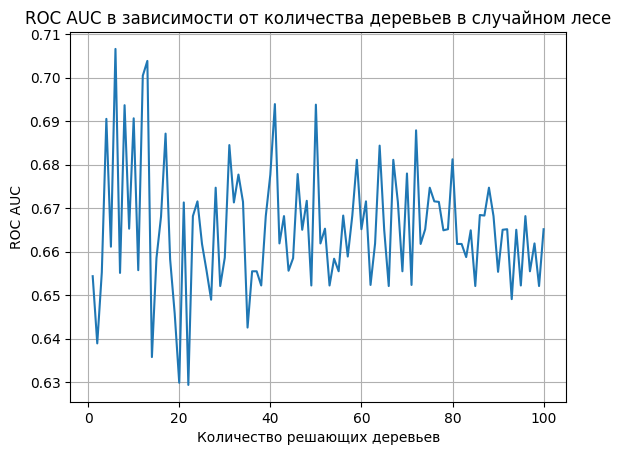

In [69]:
plt.plot(estimators, roc_auc)
plt.grid()
plt.title('ROC AUC в зависимости от количества деревьев в случайном лесе')
plt.xlabel('Количество решающих деревьев')
plt.ylabel('ROC AUC')
plt.show()

 Итак, по данному графику можно сделать вывод, что значение метрики ROC AUC не имеет монотонной зависимости от количества решающих деревьев и оно хаотично уменьшается и увеличивается. Лучшими значениями количества деревьев с точки зрения этой метрики являются 2 значения в промежутке от 1 до 20 (полагаю, что это 6 и 14)

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

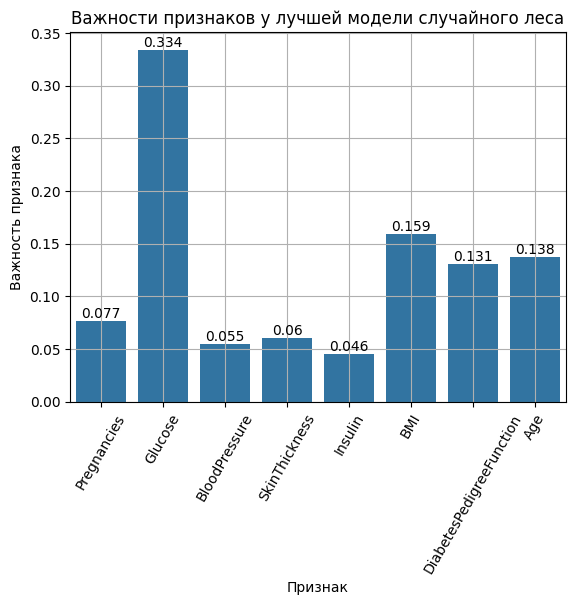

In [94]:
ax = sns.barplot(random_forest.feature_importances_)
for i, value in enumerate(random_forest.feature_importances_):
    ax.text(i, value, str(round(value, 3)), ha='center', va='bottom')
plt.title('Важности признаков у лучшей модели случайного леса')
plt.xlabel('Признак')
plt.ylabel('Важность признака')
plt.xticks(ticks=range(0, X_train.shape[1]), labels=list(X_train.columns), rotation=60)
plt.grid()
plt.show()

По данной гистограмме видим, что самый важный признак для определения диабета с точки зрения алгоритма случайного леса - уровень глюкозы в крови